# Customer Segmentation

This project is a customer segmentation and analysis project that uses RFM (Recency, Frequency, Monetary) analysis, clustering, and other techniques to understand customer behavior for an e-commerce business. The project also uses techniques such as Principal Component Analysis (PCA) for visualization, K-Means clustering for segmentation, and association rule mining to identify cross-sell opportunities.

The overarching question you are trying to answer is: **"How can we segment customers effectively and use that segmentation to create targeted marketing and sales strategies?"** By understanding different segments of the customer base, we can apply different marketing, sales, and retention strategies, ultimately improving revenue and customer loyalty.

##### **Dataset**

The dataset used for this analysis contains transactional records from a UK-based non-store online retailer. Key features of the dataset include:

- **Invoice**: Unique identifier for each transaction.
- **StockCode**: Product code for each item purchased.
- **Description**: Name of the product.
- **Quantity**: Quantity of each product purchased.
- **InvoiceDate**: Date and time of the transaction.
- **Price**: Unit price of each product.
- **CustomerID**: Unique identifier for each customer.
- **Country**: The country of the customer (mostly from the United Kingdom).

The dataset contains over 400,000 transaction records, and this analysis focuses on segmenting customers based on their transaction history.

### 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import zipfile
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

### 2. Load Data

In [2]:
# Unzipping and loading the Excel file

with zipfile.ZipFile('Online retail.zip', 'r') as zip_ref:
    zip_ref.extractall('Online_Retail')

# Load the Excel file into a DataFrame
df = pd.read_excel('Online_Retail/online_retail_II.xlsx')

# Data Exploration and Preprocessing
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())


Missing values in the dataset:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


### 3. Clean Data

In [4]:
# Handling FutureWarning by avoiding inplace=True
df['Description'] = df['Description'].fillna('Unknown')  # Impute missing descriptions
df.dropna(subset=['Customer ID'], inplace=True)  # Drop rows with missing CustomerID

# Ensure 'Invoice' is treated as a string and handle missing values
df['Invoice'] = df['Invoice'].astype(str)
df = df[~df['Invoice'].str.startswith('C', na=False)]  # Remove rows with cancellations

# Convert 'InvoiceDate' to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

The first major goal in the code is to segment customers into clusters based on their purchasing behavior. This is achieved by creating **RFM (Recency, Frequency, Monetary)** features for each customer, which helps to assess their purchasing patterns. The segmentation process identifies groups of customers that behave similarly, which can be useful for marketing or sales strategies.

This part of the code ensures that the customers are clustered into different groups based on their **Recency** (how recently they bought), **Frequency** (how often they buy), and **Monetary** (how much they spend).

In [5]:
# Feature Engineering (Creating Recency, Frequency, and Monetary features)
current_date = df['InvoiceDate'].max()
df['Recency'] = (current_date - df['InvoiceDate']).dt.days

# Calculate TotalSpent (Quantity * Price)
df['TotalSpent'] = df['Quantity'] * df['Price']

# Frequency: Total number of transactions per customer
frequency = df.groupby('Customer ID')['Invoice'].nunique()

# Monetary: Total spent per customer
monetary = df.groupby('Customer ID')['TotalSpent'].sum()

# Create a new DataFrame for RFM features
rfm_df = pd.DataFrame({
    'Recency': df.groupby('Customer ID')['Recency'].min(),
    'Frequency': frequency,
    'Monetary': monetary
}).reset_index()

# Scaling the Data for clustering
scaler = StandardScaler()
rfm_scaled = pd.DataFrame(scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]), 
                          columns=['Recency', 'Frequency', 'Monetary'])

In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID,Recency,TotalSpent
count,407695.000000,407695,407695.000000,407695.000000,407695.000000,407695.000000
mean,13.586686,2010-07-01 10:10:10.782177792,3.294188,15368.504107,161.131088,21.663261
min,1.000000,2009-12-01 07:45:00,0.000000,12346.000000,0.000000,0.000000
25%,2.000000,2010-03-26 14:01:00,1.250000,13997.000000,56.000000,4.950000
50%,5.000000,2010-07-09 15:46:00,1.950000,15321.000000,153.000000,11.900000
75%,12.000000,2010-10-14 17:09:00,3.750000,16812.000000,258.000000,19.500000
max,19152.000000,2010-12-09 20:01:00,10953.500000,18287.000000,373.000000,15818.400000
std,96.842229,NaN,34.756655,1679.795700,113.458556,77.147356


### Key Findings

- **Quantity**: The majority of transactions involve a small number of items (median of 5), but there are also a few large orders.
- **Price**: Prices are generally low, with most items priced below £4, but there are outliers with very high prices.
- **Customer Behavior**: Customers are quite varied in their behavior. Some have made a purchase very recently, while others haven't purchased in a long time.
- **Clusters**: Most of the customers belong to Cluster 1, suggesting that this is the dominant group, while Clusters 2 and 3 have fewer members.
- **Lifespan**: The average customer lifespan is around 287 days, but there is significant variation in how long customers stay engaged.

### 4. Apply K-Means Clustering

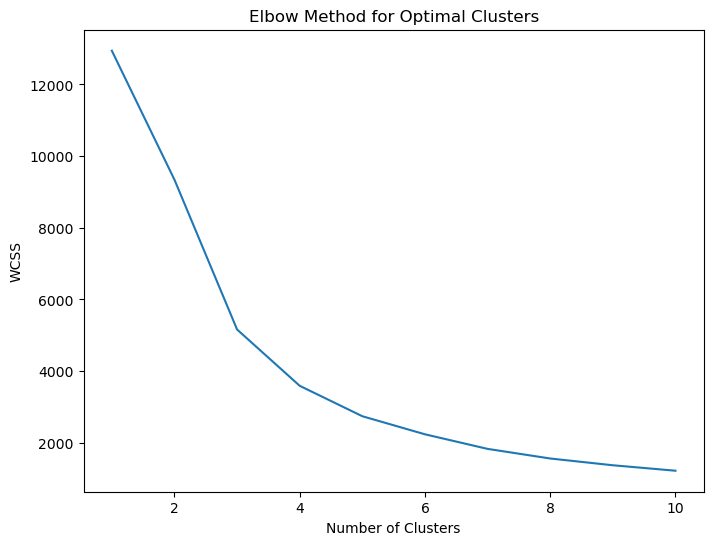

In [7]:
# Apply K-Means Clustering
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

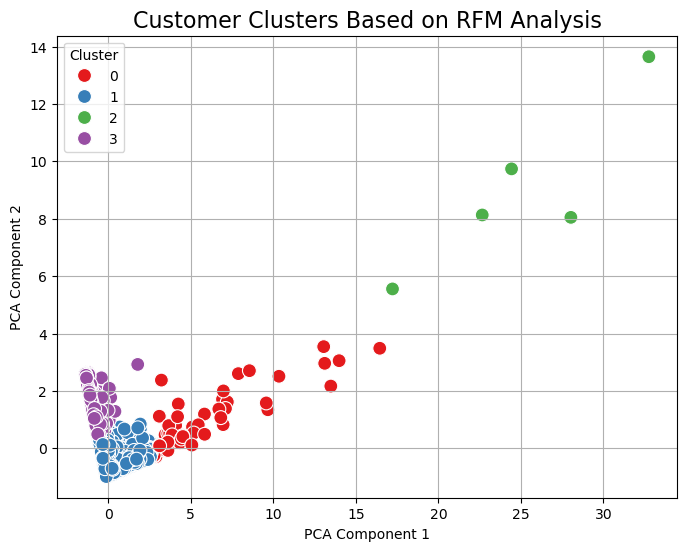

In [9]:
# PCA for Visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=rfm_pca[:, 0], y=rfm_pca[:, 1], hue=rfm_df['Cluster'], palette='Set1', s=100)
plt.title('Customer Clusters Based on RFM Analysis', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

### 5. Analyzing the Cluster Centers

#### **Identifying Customer Behavior Patterns**

Once the clusters are created, understanding customer behavior within each segment is crucial. The goal is to analyze how different clusters behave, for example, their spending habits, purchasing frequency, or recency of purchases.

In [10]:
cluster_centers = kmeans.cluster_centers_
original_centers = scaler.inverse_transform(cluster_centers)

# Create a DataFrame to view the cluster centers
cluster_centers_df = pd.DataFrame(original_centers, columns=['Recency', 'Frequency', 'Monetary'])
print(cluster_centers_df)

# Cluster Summary: Mean, Median, Std
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std']
})
print(cluster_summary)

      Recency   Frequency       Monetary
0   13.271186   46.033898   28018.434966
1   42.069978    4.433302    1710.796375
2    4.600000  113.600000  215543.670000
3  242.086749    1.658723     595.746486
            Recency                     Frequency                    \
               mean median        std        mean median        std   
Cluster                                                               
0         13.271186    3.0  34.983164   46.033898   38.0  29.692659   
1         42.069978   32.0  34.892130    4.433302    3.0   4.129997   
2          4.600000    6.0   4.335897  113.600000   94.0  51.829528   
3        242.086749  233.0  66.006022    1.658723    1.0   1.221555   

              Monetary                           
                  mean     median           std  
Cluster                                          
0         28018.434966   20329.68  19699.235589  
1          1710.796375     924.52   2320.354547  
2        215543.670000  196566.74  87157.722931

### Key Findings

- **Cluster 0**: High frequency of purchases, very recent buyers, and significant spending. This could be your "loyal customers" or "big spenders."
- **Cluster 1**: Moderate recency, low frequency of purchases, and low spending. This group may include occasional or budget-conscious customers.
- **Cluster 2**: Very recent buyers with extremely high frequency and spending. These could be your "big spenders" or "whale customers."
- **Cluster 3**: Infrequent and low spenders with a very long recency period. These customers might be dormant or one-time purchasers.

In [11]:
# Cluster Counts
cluster_counts = rfm_df['Cluster'].value_counts()
print("\nCluster Counts:")
print(cluster_counts)


Cluster Counts:
Cluster
1    3201
3    1049
0      59
2       5
Name: count, dtype: int64


### Key Findings

- **Cluster 1** has the largest number of customers, which could indicate that this cluster represents a larger, more general segment of your customer base.
- **Cluster 3** has a smaller, but still notable, group of customers. This group could represent a specific customer type (e.g., less frequent or low-spending customers).
- **Cluster 0** has very few customers (59), which suggests that this group might consist of a very niche or high-value segment.
- **Cluster 2** is the smallest group with only 5 customers, which could represent an extremely high-value segment but with a very limited number of people. This may require special attention for targeted marketing.

### 6. Sales Trends & Seasonality Analysis

Here, you can examine customer spending behavior for each cluster over time (e.g., monthly trends) and also compare how different clusters (high-value vs. low-value) respond to factors like recency or frequency of purchases.

In [ ]:
# Adding Month and Year columns to the dataset
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Aggregate sales by Month and Year
monthly_sales = df.groupby(['Year', 'Month'])['TotalSpent'].sum().reset_index()

# Plotting Monthly Sales Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x='Month', y='TotalSpent', hue='Year', marker='o')
plt.title('Monthly Sales Trends by Year', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.xticks(np.arange(1, 13, step=1))
plt.grid(True)
plt.show()

# How do sales differ across customer clusters by month?
cluster_sales = df.merge(rfm_df[['Customer ID', 'Cluster']], on='Customer ID', how='left')
cluster_monthly_sales = cluster_sales.groupby(['Year', 'Month', 'Cluster'])['TotalSpent'].sum().reset_index()

# Plotting Sales Trends by Cluster
plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_monthly_sales, x='Month', y='TotalSpent', hue='Cluster', marker='o')
plt.title('Sales Trends by Customer Cluster', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.xticks(np.arange(1, 13, step=1))
plt.grid(True)
plt.show()

### 7. Customer Retention and Churn Analysis

Another objective of this analysis is **to identify customers who are at risk of churning** (i.e., not purchasing for a long time) and to identify loyal customers who are likely to stay. The goal here is to define which customers are likely to churn based on their recency (e.g., no purchase in the last 6 months) and identify loyal customers who have made frequent purchases in the past month.

In [ ]:
# Customers who have not purchased recently (Churned Customers)
churned_customers = rfm_df[rfm_df['Recency'] > 180]  # Churn if last purchase > 6 months ago
print(f"Churned Customers (not purchased in the last 6 months): {churned_customers.shape[0]}")

# Frequency of purchases vs Recency: Scatter plot of Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm_df, x='Recency', y='Frequency', hue='Cluster', palette='Set1', s=100)
plt.title('Recency vs Frequency (Customer Retention)', fontsize=16)
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Frequency (Number of Purchases)')
plt.grid(True)
plt.show()

# Analyze retention by Cluster: What percentage of each cluster is likely to churn (Recency > 180)?
retention_by_cluster = churned_customers.groupby('Cluster').size() / cluster_counts * 100
print("\nRetention by Cluster (% of churned customers):")
print(retention_by_cluster)

# Analyzing Recency-Frequency for potential marketing strategies
# Customers with high Frequency and low Recency (Loyal Customers) can be targeted for retention
loyal_customers = rfm_df[(rfm_df['Recency'] < 30) & (rfm_df['Frequency'] > 5)]
print(f"Loyal Customers (Recency < 30 days and Frequency > 5): {loyal_customers.shape[0]}")

### Key Findings

This output shows the retention rate (as a percentage of churned customers) by cluster:

- **Cluster 0**: has an extremely low retention rate (1.69%). This suggests that customers in this group have a very high likelihood of churning. These customers may require focused retention strategies.
- **Cluster 1** and **Cluster 2**: lack retention data (NaN), which could mean either the data for these clusters is incomplete or that retention information wasn’t available or calculated for them.
- **Cluster 3**: shows a very high retention rate (78.74%), indicating that this group has a relatively strong ability to retain customers even after they may have initially churned. This group could potentially be more loyal or less likely to churn.

There are 674 customers who are considered loyal, based on the criteria of being recent and frequent buyers. These customers are important for retention and can be targeted with loyalty programs, exclusive offers, or other customer engagement strategies.

### 8. Marketing Strategy Based on Customer Segments

Once customer segments are identified and retention patterns are understood, the goal is to design tailored marketing strategies based on customer behaviors.

In [ ]:
# Identifying high-value clusters (customers who spent the most money)
high_value_clusters = rfm_df.groupby('Cluster')['Monetary'].mean().sort_values(ascending=False)
print("\nHigh-Value Clusters (mean Monetary Spend):")
print(high_value_clusters)

# Analyzing Marketing Strategy:
# - For High-Value Clusters: We can focus on loyalty programs and personalized discounts.
# - For Low-Value and Churned Clusters: We can target them with special promotions and incentives to return.
high_value_customers = rfm_df[rfm_df['Cluster'] == high_value_clusters.idxmax()]
print(f"High-Value Customers: {high_value_customers.shape[0]}")

# Analyzing customers who have the lowest Recency and high Frequency (loyal customers)
loyal_customers = rfm_df[(rfm_df['Recency'] < 30) & (rfm_df['Frequency'] > 5)]
print(f"Loyal Customers (Recency < 30 days, Frequency > 5): {loyal_customers.shape[0]}")

### Key Findings

- **Cluster 2** has the highest average spending by a wide margin (£215,543.67). This indicates that the customers in this group are high-value customers, contributing significantly to the business revenue. Despite the small size of the group (only 5 customers), they are major contributors to the business.
- **Cluster 0** also has relatively high spending (£28,018.43), though it's significantly lower than Cluster 2. This cluster could represent high-frequency, high-spending but slightly less "elite" customers than Cluster 2.
- **Cluster 1** has much lower average spending (£1,710.80), indicating that this group spends significantly less compared to the other clusters.
- **Cluster 3** has the lowest average spend (£595.75), meaning that customers in this cluster are likely low-value customers in terms of monetary contribution.

### Suggested Strategy

The code helps tailor marketing strategies:

- For high-value customers, you could focus on loyalty programs or personalized discounts.
- For churned or low-value customers, you could run special promotions or incentives to drive them back.

### 9. Customer Segments Overview


Cluster Summary:
            Recency                     Frequency                    \
               mean median        std        mean median        std   
Cluster                                                               
0         13.271186    3.0  34.983164   46.033898   38.0  29.692659   
1         42.069978   32.0  34.892130    4.433302    3.0   4.129997   
2          4.600000    6.0   4.335897  113.600000   94.0  51.829528   
3        242.086749  233.0  66.006022    1.658723    1.0   1.221555   

              Monetary                           
                  mean     median           std  
Cluster                                          
0         28018.434966   20329.68  19699.235589  
1          1710.796375     924.52   2320.354547  
2        215543.670000  196566.74  87157.722931  
3           595.746486     306.00   1449.148948  


C:\Users\milto\AppData\Local\Temp\ipykernel_19932\4057197000.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Recency', data=rfm_df, estimator=np.mean, palette='coolwarm')


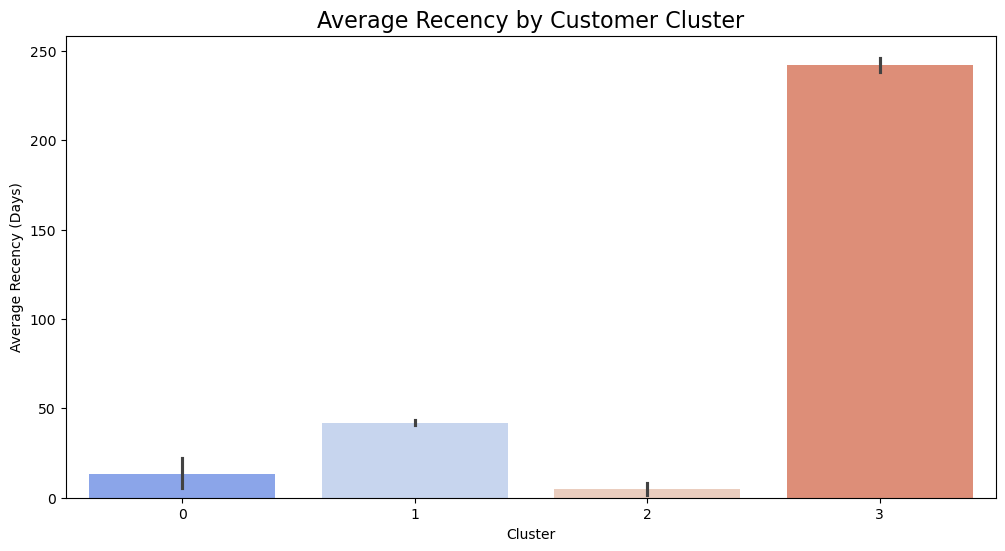

C:\Users\milto\AppData\Local\Temp\ipykernel_19932\4057197000.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Frequency', data=rfm_df, estimator=np.mean, palette='coolwarm')


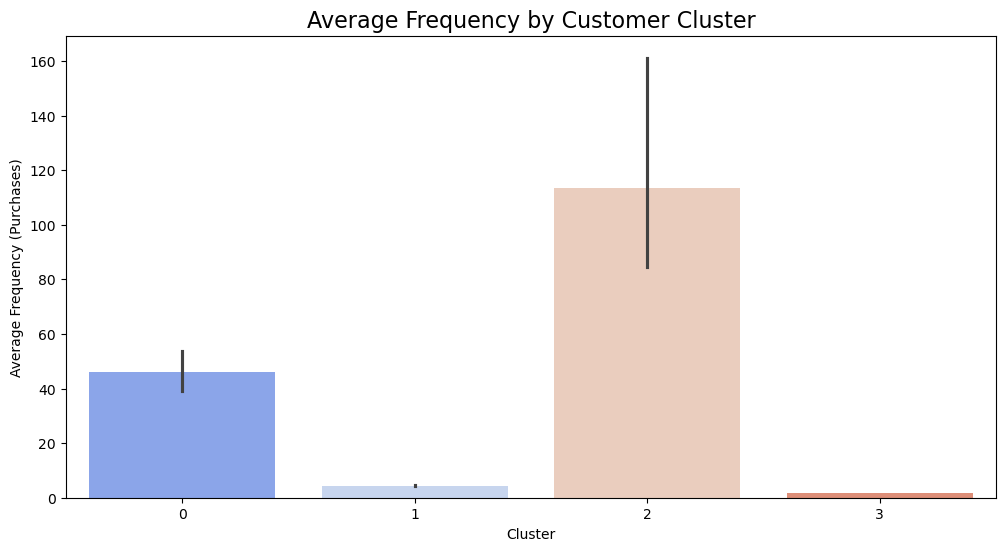

C:\Users\milto\AppData\Local\Temp\ipykernel_19932\4057197000.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Monetary', data=rfm_df, estimator=np.mean, palette='coolwarm')


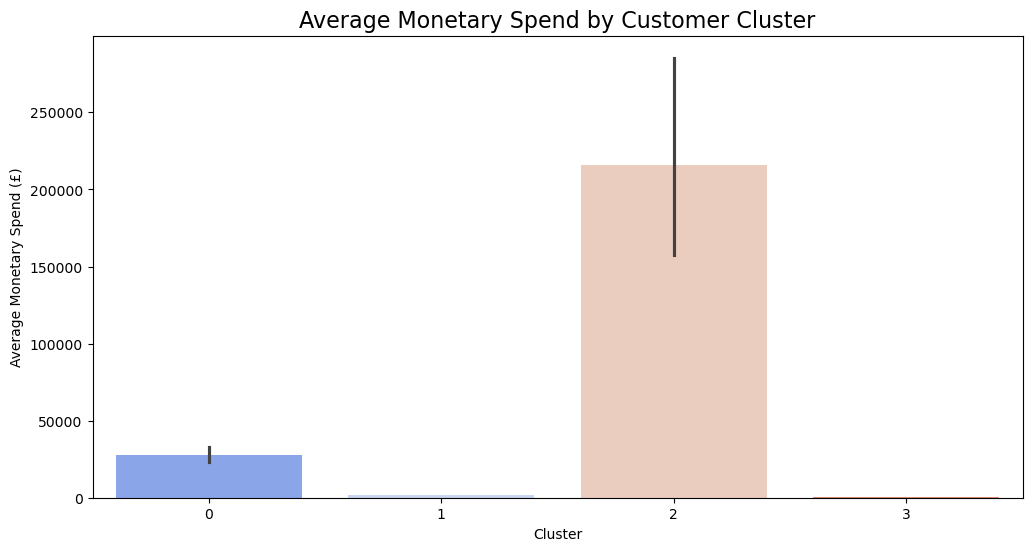

In [12]:
# Cluster Analysis Summary
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'],
    'Monetary': ['mean', 'median', 'std']
})
print("\nCluster Summary:")
print(cluster_summary)

# Visualizing Cluster Profiles
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Recency', data=rfm_df, estimator=np.mean, palette='coolwarm')
plt.title('Average Recency by Customer Cluster', fontsize=16)
plt.ylabel('Average Recency (Days)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Frequency', data=rfm_df, estimator=np.mean, palette='coolwarm')
plt.title('Average Frequency by Customer Cluster', fontsize=16)
plt.ylabel('Average Frequency (Purchases)')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Monetary', data=rfm_df, estimator=np.mean, palette='coolwarm')
plt.title('Average Monetary Spend by Customer Cluster', fontsize=16)
plt.ylabel('Average Monetary Spend (£)')
plt.show()

### Key Findings

#### Recency
- **Cluster 0** has a low average Recency (13.27), with a median of 3, indicating that on average, customers in this cluster made recent purchases, but there's high variance (Std = 34.98), meaning some customers might not have purchased in a while.
- **Cluster 1** has the highest Recency (42.07), with a median of 32. This could suggest that customers in this group made their last purchase a long time ago. The higher standard deviation (Std = 34.89) also suggests varied behavior among customers in this cluster.
- **Cluster 2** has the lowest Recency (4.60), with a median of 6, indicating that these customers are fairly recent in their purchasing behavior and quite consistent in frequency (low Std).
- **Cluster 3** has the highest Recency (242.09), suggesting that these customers haven’t made recent purchases. The median of 233 and high Std indicate these customers are quite distant from the current time.

#### Frequency
- **Cluster 0** has a high average Frequency (46.03) with a relatively high median (38), suggesting that these customers purchase frequently. The high Std (29.69) indicates a large variance in the frequency of purchases within this cluster.
- **Cluster 1** has the lowest Frequency (4.43), suggesting that customers in this group make fewer purchases. The median (3) is low, and the Std (4.13) indicates that there are some customers with higher frequency but most have very low frequency.
- **Cluster 2** has a high Frequency (113.60) with a median of 94, meaning that customers in this group make frequent purchases, and the Std (51.83) indicates some variation in their buying behavior.
- **Cluster 3** has the lowest Frequency (1.66), with a median of 1, indicating that most customers in this group purchase very infrequently. The low Std (1.22) suggests consistency in their behavior.

#### Monetary:
- **Cluster 0** shows a high Monetary value (mean = 28,018.43), suggesting that this group is a high-spending customer base, with a reasonably high median (20,329.68). The Std (19,699.24) indicates a lot of variance in spending behavior.
- **Cluster 1** has significantly lower Monetary values (mean = 1,710.80), indicating lower overall spending. The median (924.52) supports this, and the Std (2,320.35) suggests some high-value outliers in this group.
- **Cluster 2** has an exceptionally high Monetary value (mean = 215,543.67), indicating that this is a high-value customer segment. The median (196,566.74) is also very high, showing that most customers in this cluster are big spenders, with significant variance (Std = 87,157.72).
- **Cluster 3** has a much lower Monetary value (mean = 595.75), which aligns with the lower frequency and recency observed earlier. These customers are likely low-spending and infrequent purchasers.

### 10. Customer Lifetime Value (CLV) Calculation

Calculating **CLV** provides a metric to estimate the total worth of a customer over time, helping to prioritize efforts towards more profitable customers. CLV is then calculated for each customer and aggregated to analyze the total value of customers in each cluster. This helps you identify **high-value customers** who can drive long-term profitability.

In [ ]:
# Customer Lifetime Value (CLV) is a predictive metric to estimate how valuable a customer will be over time. A simple formula for CLV could be:
# CLV=Average Purchase Value×Purchase Frequency×Customer Lifespan
# This analysis shows the average CLV per cluster. You can use this information to focus on high-value customers with a strong potential for repeat business.

# Calculate Average Purchase Value for each customer
avg_purchase_value = df.groupby('Customer ID')['TotalSpent'].sum() / df.groupby('Customer ID')['Invoice'].nunique()

# Calculate Purchase Frequency: the number of transactions per customer
purchase_frequency = df.groupby('Customer ID')['Invoice'].nunique()

# Calculate Customer Lifespan: the number of days since the first purchase
df['FirstPurchase'] = df.groupby('Customer ID')['InvoiceDate'].transform('min')
df['Lifespan'] = (current_date - df['FirstPurchase']).dt.days

# Now calculate CLV: 
# CLV = Average Purchase Value * Purchase Frequency * Customer Lifespan
clv = avg_purchase_value * purchase_frequency * df.groupby('Customer ID')['Lifespan'].max()

# Create a CLV DataFrame
clv_df = pd.DataFrame({'Customer ID': clv.index, 'CLV': clv.values}).reset_index(drop=True)

# Merge CLV with the original customer data (for segmentation)
rfm_df = rfm_df.merge(clv_df, on='Customer ID', how='left')

# Explore the distribution of CLV across clusters
plt.figure(figsize=(12, 6))
sns.boxplot(data=rfm_df, x='Cluster', y='CLV', palette='Set2')
plt.title('Customer Lifetime Value (CLV) by Cluster', fontsize=16)
plt.xlabel('Cluster')
plt.ylabel('CLV (£)')
plt.show()

# Calculate and display the mean CLV by cluster
clv_by_cluster = rfm_df.groupby('Cluster')['CLV'].mean()
print("\nAverage CLV by Cluster:")
print(clv_by_cluster)

### Interpretation

- **Cluster 2** has an extremely high CLV (80,269,240), reflecting the high Monetary spend in this group. These are your most valuable customers.
- **Cluster 0** also has a high CLV (9,851,928), though significantly lower than Cluster 2, but still indicates a high lifetime value due to frequent and high-value purchases.
- **Cluster 1** has a moderate CLV (478,710), indicating that while customers here spend less, they still contribute a solid amount to revenue.
- **Cluster 3** has the lowest CLV (173,470), which aligns with the low spending and infrequency of purchases in this group.

### 11. Cross-Sell Opportunities (Using Association Rule Mining - Apriori Algorithm)

Finally, the project aims to identify **cross-sell opportunities** using association rule mining (e.g., customers who bought X are likely to buy Y), which helps in recommending complementary products. The **association rules** help you find frequently bought product pairs, which can be used for cross-selling—for example, recommending products based on what customers have already purchased.

                            antecedents                           consequents  \
0         (60 TEATIME FAIRY CAKE CASES)      (72 SWEETHEART FAIRY CAKE CASES)   
1      (72 SWEETHEART FAIRY CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   
2      (PACK OF 60 DINOSAUR CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   
3         (60 TEATIME FAIRY CAKE CASES)      (PACK OF 60 DINOSAUR CAKE CASES)   
4         (60 TEATIME FAIRY CAKE CASES)      (PACK OF 60 MUSHROOM CAKE CASES)   
5      (PACK OF 60 MUSHROOM CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   
6         (60 TEATIME FAIRY CAKE CASES)  (PACK OF 60 PINK PAISLEY CAKE CASES)   
7  (PACK OF 60 PINK PAISLEY CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   
8         (60 TEATIME FAIRY CAKE CASES)      (PACK OF 60 SPACEBOY CAKE CASES)   
9      (PACK OF 60 SPACEBOY CAKE CASES)         (60 TEATIME FAIRY CAKE CASES)   

    support  confidence      lift  
0  0.018787    0.317782  8.798523  
1  0.018787    0.520173  8.798523  


C:\Users\milto\AppData\Local\Temp\ipykernel_19932\2230193619.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=frequent_itemsets.nlargest(10, 'support'), x='support', y='itemsets', palette='Set1')


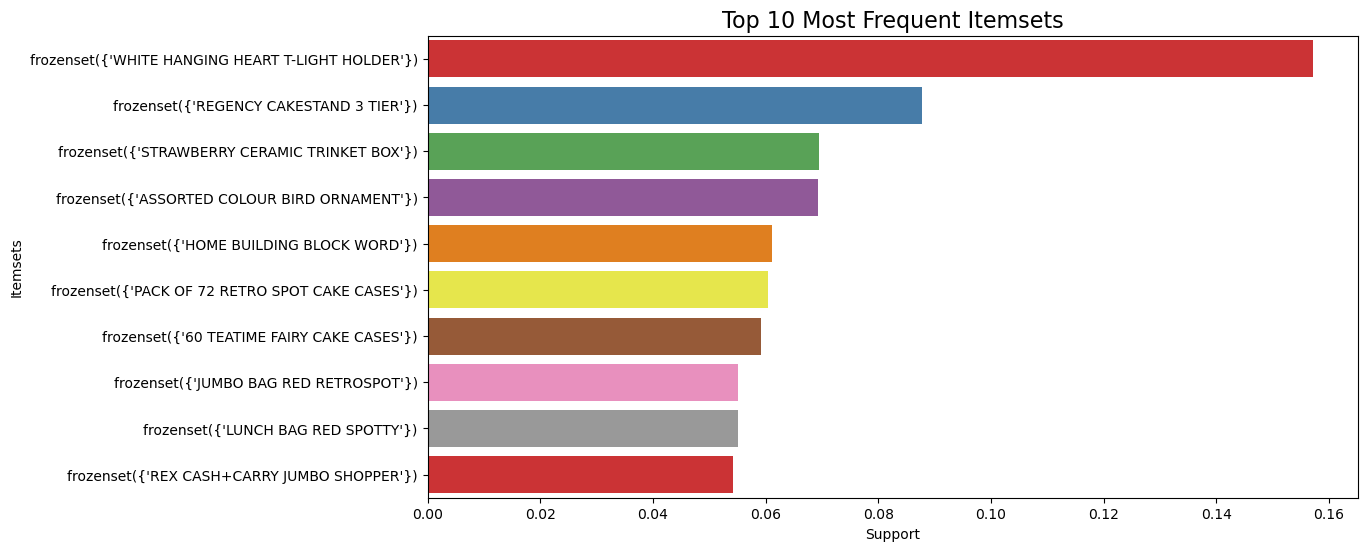

In [13]:
# The association rules can help identify product pairs or groups that are frequently bought together, such as "customers who bought X also bought Y."
# The Lift metric in association rules can be used to evaluate the strength of relationships: higher lift means stronger associations between products.

# Prepare the data for association rule mining: Transform each transaction into a list of items
transactions = df.groupby('Invoice')['Description'].apply(list).reset_index()

# Transaction Encoding: Convert list of products into a binary matrix
te = TransactionEncoder()
te_ary = te.fit_transform(transactions['Description'])

# Create a DataFrame of transaction data
trans_df = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets using Apriori
# frequent_itemsets = apriori(trans_df, min_support=0.05, use_colnames=True)
frequent_itemsets = apriori(trans_df, min_support=0.01, use_colnames=True)

# Generate association rules
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display the top 10 rules based on lift
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

# Visualize the most frequent items (support > 0.05) using bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=frequent_itemsets.nlargest(10, 'support'), x='support', y='itemsets', palette='Set1')
plt.title('Top 10 Most Frequent Itemsets', fontsize=16)
plt.xlabel('Support')
plt.ylabel('Itemsets')
plt.show()

### Key Findings

#### Strong Associations:
- Items like "72 SWEETHEART FAIRY CAKE CASES" and "60 TEATIME FAIRY CAKE CASES" have a high lift (around 8.8), meaning that when one is bought, the likelihood of purchasing the other is significantly higher than random chance.
- Other combinations, such as "PACK OF 60 DINOSAUR CAKE CASES" and "60 TEATIME FAIRY CAKE CASES," also show a strong positive relationship with high lift values (around 9.88).

#### Confidence:
- Some rules have high confidence (e.g., "PACK OF 60 DINOSAUR CAKE CASES" → "60 TEATIME FAIRY CAKE CASES" with 58.4% confidence), which means that in over half of the transactions that involve "PACK OF 60 DINOSAUR CAKE CASES," "60 TEATIME FAIRY CAKE CASES" is also bought.

#### Support:
- The support values are relatively low (less than 2%) for most rules, which means that while these associations are strong, they don't appear in the majority of transactions.

### 12. Price Sensitivity Analysis

You also want to understand how **different customer clusters react to price changes**, which is useful for setting pricing strategies. The **price sensitivity analysis** helps us to understand whether some customer segments are more likely to be influenced by price changes, guiding discounting strategies or promotional pricing.

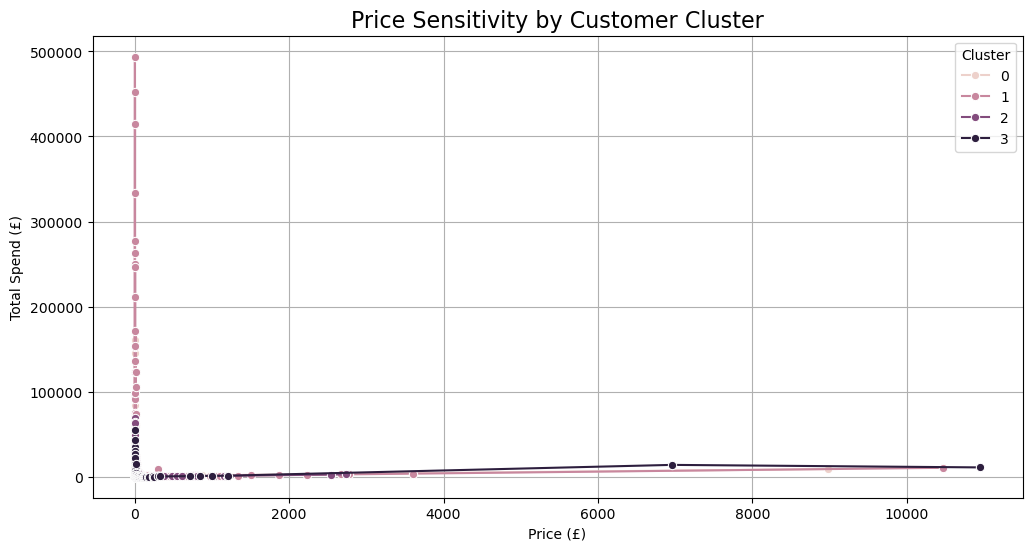

In [14]:
# Price sensitivity refers to how much customers’ purchasing behavior changes in response to price changes. To explore price sensitivity, we can analyze how customers in different clusters respond to variations in the unit price.

# Analyze Price Sensitivity by Cluster: How does the total amount spent vary with price changes?
# Merge the Cluster labels back to the original df DataFrame
df = df.merge(rfm_df[['Customer ID', 'Cluster']], on='Customer ID', how='left')

# Price Sensitivity Analysis
# Analyze Price Sensitivity by Cluster: How does the total amount spent vary with price changes?
price_sensitivity = df.groupby(['Cluster', 'Price'])['TotalSpent'].sum().reset_index()

# Visualize Price Sensitivity by Cluster
plt.figure(figsize=(12, 6))
sns.lineplot(data=price_sensitivity, x='Price', y='TotalSpent', hue='Cluster', marker='o')
plt.title('Price Sensitivity by Customer Cluster', fontsize=16)
plt.xlabel('Price (£)')
plt.ylabel('Total Spend (£)')
plt.grid(True)
plt.show()

Thw Price-Sensitivity by Cluster allows us to evaluate which customer segments are more sensitive to price changes, helping in setting the right pricing strategy.

Cluster 3 - Price and Total Spend Correlation: 0.83
Cluster 1 - Price and Total Spend Correlation: 0.50
Cluster 0 - Price and Total Spend Correlation: 0.31
Cluster 2 - Price and Total Spend Correlation: 0.20


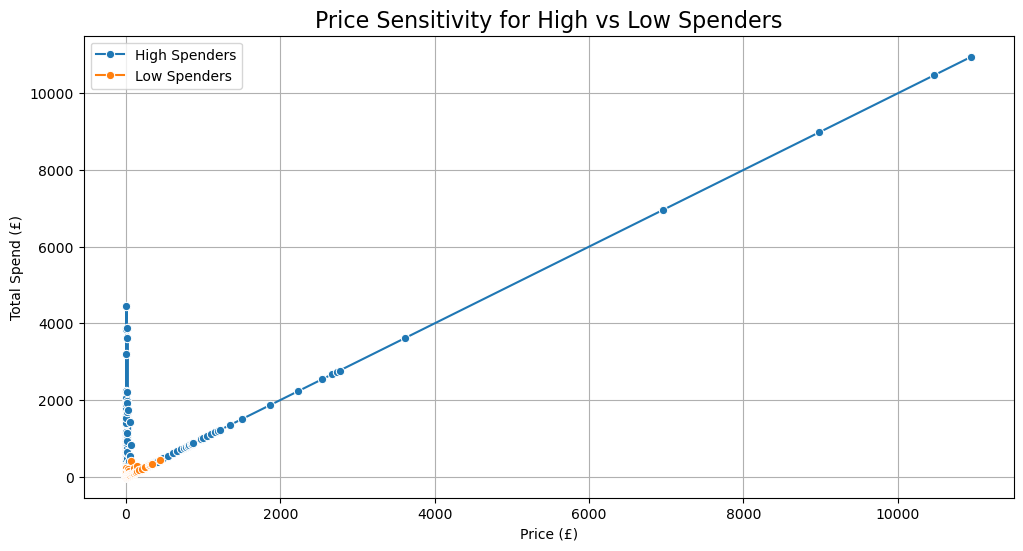

In [15]:
# Correlation between price and total spend by cluster
# Correlation analysis will give a quick view of the relationship between Price and Total Spend in each cluster.
for cluster in rfm_df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    correlation = cluster_data[['Price', 'TotalSpent']].corr().iloc[0, 1]
    print(f"Cluster {cluster} - Price and Total Spend Correlation: {correlation:.2f}")

# Analyzing Price Sensitivity for Low and High Value Customers (high spenders vs low spenders)
high_spenders = rfm_df[rfm_df['Monetary'] > rfm_df['Monetary'].median()]
low_spenders = rfm_df[rfm_df['Monetary'] <= rfm_df['Monetary'].median()]

# Merge high_spenders and low_spenders with df to include 'Price' and 'TotalSpent' columns
high_spenders_df = df[df['Customer ID'].isin(high_spenders['Customer ID'])]
low_spenders_df = df[df['Customer ID'].isin(low_spenders['Customer ID'])]

# Plot the price vs total spend for high and low spenders
plt.figure(figsize=(12, 6))
sns.lineplot(data=high_spenders_df, x='Price', y='TotalSpent', label='High Spenders', marker='o')
sns.lineplot(data=low_spenders_df, x='Price', y='TotalSpent', label='Low Spenders', marker='o')
plt.title('Price Sensitivity for High vs Low Spenders', fontsize=16)
plt.xlabel('Price (£)')
plt.ylabel('Total Spend (£)')
plt.legend()
plt.grid(True)
plt.show()

The line plot show how spending changes with price variations for different customer clusters. The comparison between high and low spenders can help tailor different pricing strategies (e.g., discounts for low spenders or premium pricing for high spenders).

### Interpretation

- **Cluster 3** has the highest correlation between Price and Total Spend (0.83), which suggests that customers in this group are very price-sensitive, meaning they tend to spend more as prices increase.
- **Cluster 1** has a moderate correlation (0.50), indicating some positive relationship between price and spending, but it's less pronounced than in Cluster 3.
- **Cluster 0** has a low correlation (0.31), suggesting that customers in this group are not strongly influenced by price when deciding how much to spend.
- **Cluster 2** has the lowest correlation (0.20), suggesting that price does not significantly impact the spending behavior of these customers, who likely make large purchases regardless of price fluctuations.

## Key Findings:

#### Customer Segments:
- **Cluster 0** (Loyal Customers or Big Spenders) consists of customers with high purchase frequency, relatively recent activity, and significant spending. Although this group is small, it contributes significantly to revenue, with a notably high Customer Lifetime Value (CLV).
- **Cluster 1** (Occasional or Budget-Conscious Customers) is the largest group, indicating that this is the broadest customer segment. They make fewer purchases and spend less, but they represent a large proportion of the customer base. Targeting them with promotional offers could enhance engagement.
- **Cluster 2** (High-Value "Whale" Customers) is the smallest but most profitable group. These customers exhibit exceptional spending behavior and have an extremely high CLV, making them critical for business success. They represent a unique opportunity for premium services or exclusive offers.
- **Cluster 3** (Infrequent and Low-Spending Customers) has a very low retention rate, indicating that they are at high risk of churning. With low frequency and low monetary contribution, these customers may require targeted re-engagement strategies or could be deprioritized for more profitable groups.

#### Retention Insights:
- **Cluster 3** exhibits the highest retention rate, suggesting that despite infrequent purchases, this group tends to remain loyal. On the other hand, Cluster 0 has a very low retention rate, indicating that these high-frequency customers may require more robust retention strategies to prevent churn.

#### Spending Patterns:
- **Cluster 2** dominates in terms of Monetary value and CLV, with an average spend of over £215,000 per customer, contributing heavily to revenue. These customers are highly profitable but are also few in number, suggesting a niche market that deserves focused attention.
- **Cluster 0** also shows high spending, indicating that while the group is small, it plays a key role in revenue generation. In contrast, Cluster 1 and Cluster 3 are low-spending segments that may require different pricing or engagement strategies to increase their spend.

#### Association Rule Insights:
- Strong associations between certain products (e.g., “72 SWEETHEART FAIRY CAKE CASES” and “60 TEATIME FAIRY CAKE CASES”) provide opportunities for cross-selling. Targeted promotions or bundle offers can increase the likelihood of customers purchasing related items.

#### Price Sensitivity:
- **Cluster 3** is the most price-sensitive group, as indicated by a high correlation between price and total spend. This suggests that discounts or price-based promotions might be effective in increasing spending in this segment.
- **Cluster 2**, with its low price sensitivity, shows that these high-value customers make large purchases regardless of price fluctuations, indicating that they may respond better to exclusive or value-added offerings.

##### **Recommendations for Action**:

- **Loyalty Programs**: Target Cluster 0 with retention strategies such as loyalty programs, exclusive discounts, or personalized offers to reduce churn and maintain high engagement.
- **High-Value Customer Focus**: Develop tailored campaigns for Cluster 2, offering premium products or services and ensuring these customers feel valued and exclusive.
- **Increased Engagement for Cluster 1**: Explore strategies to increase the frequency and spending of Cluster 1 through marketing tactics such as promotions or discounts for bulk purchases.
- **Re-Engagement for Cluster 3**: For Cluster 3, which has lower spending and purchase frequency, consider re-engagement tactics such as targeted promotions or reminders to re-establish a purchasing habit.